# 高频数据估计2007年每日S&P100股票市场因子暴露&CAPM检验& BAB异象检验

- 代码中beta估计适用于所有数据 数据借助DataLoader迭代器输入，要求在dataroot对应文件夹中加入名为OEF与 SP的两个字文件夹，包含相同日期OEF与SP的数据
- 代码中交易日期，市值数据与股票池名称显示代码 只使用了2007年数据，增加年份需要对此其中代码进行调整


In [2]:
# 导入需要的包
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import os 
import warnings
import torch
import torch.utils.data as data
import random 
#显示设置
warnings.filterwarnings("ignore")
matplotlib.pyplot.rcParams['font.sans-serif']=['simhei'] #中文图例
pd.set_option('display.max_columns', 50)  #最多显示5列
pd.set_option('display.max_rows', 1000) #最多显示10行
matplotlib.rcParams['axes.unicode_minus']=False
colorset = [(255/256,0/256,0/256),(4/256,78/256,126/256),(255/256,128/256,128/256),(129/256,166/256,190/256),
                  (255/256,178/256,178/256),(180/256,202/256,216/256),(255/256,51/256,51/256),
                  (54/256,113/256,152/256),(0/256,0/256,0/256),(128/256,128/256,128/256)
                 ] #作图颜色



## 基本信息显示

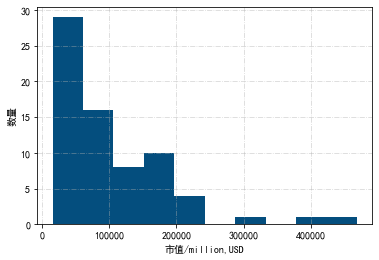

In [3]:
#交易日期
DATES=pd.read_csv('input/Selected_Dates_2017.csv').iloc[:,0]
DATES=DATES.values
#股票池名称显示
indexs=pd.read_csv('input/index.csv')
indexs=indexs.iloc[0,1:].values
stocks=pd.read_csv('input/stocks.csv',header=None)
stocks=stocks.iloc[:,1].values
stocks[indexs]
#市值数据
CAPS=pd.read_csv('input/SP100_MarketCap_70stocks_2017.csv').iloc[:,1:]
capsmean=CAPS[0:251].mean().values
plt.figure() #初始化一张图
plt.hist(capsmean,color=colorset[1])  #直方图关键操作
plt.grid(alpha=0.5,linestyle='-.') #网格线，更好看 
plt.xlabel('市值/million,USD')  
plt.ylabel('数量')  
#plt.title(r'Life cycle frequency distribution histogram of events in New York') 
plt.show()

## 估计Spot Beta
使用自写的数据迭代加载包 dataset
- dataroot对应文件夹中加入名为OEF与 SP的两个字文件夹，包含相同日期OEF与SP的数据，不包含其它数据！

使用自写的数据处理类:method Index_extract类：
- 初始化类:当日数据 OEF(format:  每日观测次数)、SP(format: 每日观测次数* 股票池个数)、N:每日观测天数、K、J：Smoothed-TSRV方法参数
- Index.get_group()：按照beta进行排序从小到大10组编号 输出结果size: 10*(股票池中个数/10)
- Index_getclose(): 输出(OEF,SP) 当日OEF，SP收盘价，输出结果size:(1，股票池个数)
- Index_get_beta(): 输出当日beta值 size:股票池个数

In [10]:
from dataset import get_dataloader
from tqdm import tqdm
from method.Index_extract import Index_extract

dataroot='input/'
data_loader = get_dataloader(dataroot)
local_progress=tqdm(data_loader)

N=4680 
K=800
J=400
NUM=70

Betas=torch.zeros([len(data_loader),NUM]).cuda().detach()         #所有天的beta （共251天，从第一天开始）
Return_rates=torch.zeros([len(data_loader)-1,10]).cuda().detach() #所有天按照beta分10组的收益率 （共250天，从第二天开始：用第一天beta构造第二天投资组合）
ReOEF=torch.zeros([len(data_loader)-1,1]).cuda().detach()  #所有天的OEF每日收益率(ln收盘价差分)  （共250天，差分结果）
ReSP=torch.zeros([len(data_loader)-1,NUM]).cuda().detach()  #所有天的SP成分股每日收益率(ln收盘价差分)  （共250天，差分结果）

for i,(SP,OEF) in enumerate(local_progress):
    Index=Index_extract(OEF,SP,N,K,J)
    if i!=0:
        (close_nowOEF,close_nowSP)=Index.get_close()
        close_diffSP=close_nowSP-close_tempSP
        close_diffOEF=close_nowOEF-close_tempOEF
        
        re_rate=close_diffSP[groups_temp].mean(1)#组内等权
        ReOEF[i-1,:]=close_diffOEF
        ReSP[i-1,:]=close_diffSP
        Return_rates[i-1,:]=re_rate
        
    groups_temp=Index.get_group() #当日分组情况:7*10
    (close_tempOEF,close_tempSP)=Index.get_close()  #当日收盘价
    Betas[i,:]=Index.get_beta()

date_num: 251


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:21<00:00, 11.74it/s]


### 上述结果可视化展示

Text(0, 0.5, 'OEF对数价格')

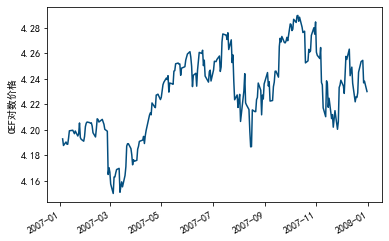

In [11]:
#画图，研究日期的对数收盘价变化
dates=pd.to_datetime(DATES[1:],format='%Y%m%d')
Dataplot1=pd.DataFrame(np.array(ReOEF.tolist()).cumsum()+4.19044231060074,index=dates)
Dataplot1[0].plot(color=colorset[1])
plt.ylabel('OEF对数价格') 

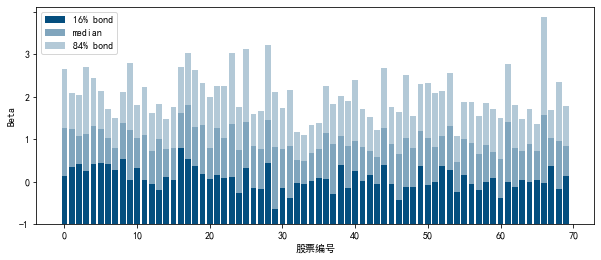

In [12]:
irfs=Return_rates.cpu().numpy()
# Beta结果描述
irfs=Betas.cpu().numpy()[:150,:]
def lb(a):
    return(np.percentile(a,16))
def ub(a):
    return(np.percentile(a,84))
def mb(a):
    return(np.percentile(a,50))
upb=np.apply_along_axis(ub,0,irfs) 
lowb=np.apply_along_axis(lb,0,irfs) 
medb=np.apply_along_axis(mb,0,irfs) 

shops = range(70)
Lowb = lowb+1
Medb= medb+1
Upb = upb+1

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_yticklabels(range(-1, 4))
ax.bar(shops, Lowb, color=colorset[1], label="16% bond")
ax.bar(shops, Medb-Lowb, color=colorset[3], bottom=Lowb, label="median")
ax.bar(shops, Upb-Medb, color=colorset[5], 
       bottom=Medb, label="84% bond")

ax.set_xlabel("股票编号")
ax.set_ylabel("Beta")
ax.legend()

## J,K参数对beta的影响

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
(SP,OEF)=next(iter(data_loader))#取一天的值
SPsample=SP[:,:,10]
SPsample=SPsample.view(1,-1,1)

In [ ]:
betas2=torch.zeros([2000,1000,1],device=OEF.device)
for j in range(1,2000):
    for add in range(1,1000):
        Index=Index_extract(OEF,SPsample,N,j+add,j)
        betas2[j,add]=Index.get_beta()

In [48]:
betas=torch.zeros([200,20,1],device=OEF.device)
for j in range(1,200):
    for multi in range(2,20):
        Index=Index_extract(OEF,SPsample,N,j*multi,j)
        betas[j,multi]=Index.get_beta()

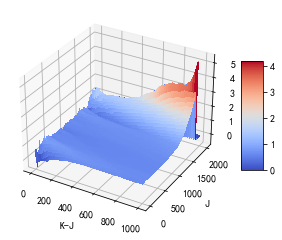

In [19]:
fig= plt.figure()
ax = fig.gca(projection='3d')
 
# Make data.
Y = np.arange(1,2000)
X = np.arange(1,1000)
X,Y=np.meshgrid(X,Y)
Z = (betas2.view(2000,1000))[1:,1:]
 
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
 
# Customize the z axis.
ax.set_ylabel('J')
ax.set_xlabel('K-J')
ax.set_zlabel('beta')
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
 
plt.show()


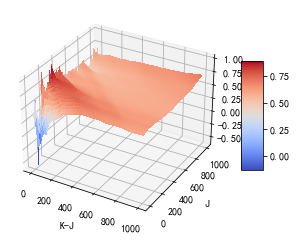

In [22]:
fig= plt.figure()
ax = fig.gca(projection='3d')
 
# Make data.
Y = np.arange(1,1000)
X = np.arange(1,1000)
X,Y=np.meshgrid(X,Y)
Z = (betas2.view(2000,1000))[1:1000,1:]
 
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
 
# Customize the z axis.
ax.set_ylabel('J')
ax.set_xlabel('K-J')
ax.set_zlabel('beta')
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
 
plt.show()


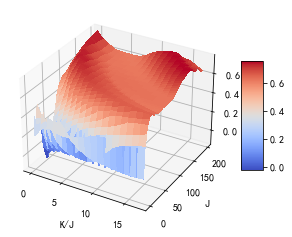

In [65]:
fig= plt.figure()
ax = fig.gca(projection='3d')
 
# Make data.
Y = np.arange(198)
X = np.arange(18)
X,Y=np.meshgrid(X,Y)
Z = (betas.view(200,20))[2:,2:]
 
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
 
# Customize the z axis.
ax.set_xlabel('K/J')
ax.set_ylabel('J')
ax.set_zlabel('beta')
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
 
plt.show()


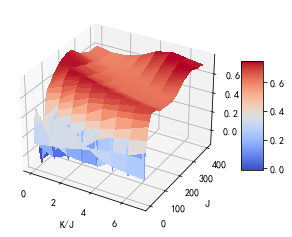

In [15]:
betas3=torch.zeros([400,10,1],device=OEF.device)
for j in range(1,400):
    for multi in range(2,10):
        Index=Index_extract(OEF,SPsample,N,j*multi,j)
        betas3[j,multi]=Index.get_beta()

fig= plt.figure()
ax = fig.gca(projection='3d')
 
# Make data.
Y = np.arange(399)
X = np.arange(8)
X,Y=np.meshgrid(X,Y)
Z = (betas3.view(400,10))[1:,2:]
 
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
 
# Customize the z axis.
ax.set_xlabel('K/J')
ax.set_ylabel('J')
ax.set_zlabel('beta')
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
 
plt.show()

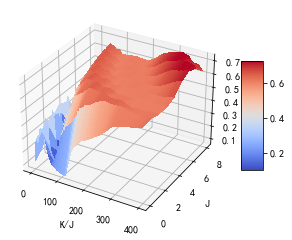

In [70]:
betas3=torch.zeros([10,400,1],device=OEF.device)
for j in range(1,10):
    for multi in range(2,400):
        Index=Index_extract(OEF,SPsample,N,j*multi,j)
        betas3[j,multi]=Index.get_beta()

fig= plt.figure()
ax = fig.gca(projection='3d')
 
# Make data.
Y = np.arange(9)
X = np.arange(398)
X,Y=np.meshgrid(X,Y)
Z = (betas3.view(10,400))[1:,2:]
 
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
 
# Customize the z axis.
ax.set_xlabel('K/J')
ax.set_ylabel('J')
ax.set_zlabel('beta')
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
 
plt.show()

## 单beta组合排序法

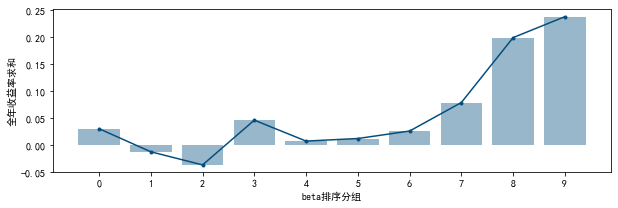

In [13]:
x = [0,1,2,3,4,5,6,7,8,9]
y = Return_rates.sum(0).tolist()
# 绘图
plt.subplots(figsize=(10, 3))
plt.bar(x,y, color=colorset[3], alpha=0.8)

# 为两条坐标轴设置名称
plt.xlabel("beta排序分组")
plt.ylabel("全年收益率求和")
# 显示图例

# 画折线图
plt.plot(x, y, color=colorset[1], marker='o', ms=3)

plt.xticks(x,x)
plt.show()


In [14]:
from scipy.stats import spearmanr, pearsonr

spearmanr(Return_rates.sum(0).tolist(),np.arange(10)) #秩相关系数检验

SpearmanrResult(correlation=0.6969696969696969, pvalue=0.02509667588225183)

In [15]:
# 最高30%beta-最低30%beta组合收益
res=(Return_rates[:,7:].mean(1)-Return_rates[:,0:3].mean(1)).tolist() #组合日收益率t检验
from scipy import stats as ss 
ss.ttest_1samp(res,0)

Ttest_1sampResult(statistic=1.673922214978958, pvalue=0.09540151991366742)

Text(0, 0.5, '全年净值')

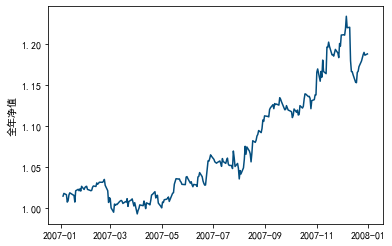

In [16]:
plt.plot(dates,(np.array(res)+1).cumprod(),color=colorset[1])
plt.ylabel("全年净值")

In [32]:
#排序法得到的收益率与OEF回归结果
xx=sm.add_constant(res)
yy=np.array((ReOEF.view(250)).tolist()).reshape(250)
model = sm.OLS(yy,xx)
results = model.fit()
results .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     57.86
Date:                Tue, 26 Apr 2022   Prob (F-statistic):           5.83e-13
Time:                        14:49:21   Log-Likelihood:                 847.09
No. Observations:                 250   AIC:                            -1690.
Df Residuals:                     248   BIC:                            -1683.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.500      0.618      -0.001       0.001
x1             0.5872      0.077      7.607      0.000       0.435       0.739
==============================================================================
Omnibus:                       41.984   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.767
Skew:                          -0.881   Prob(JB):                     1.30e-17
Kurtosis:                       5.088   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

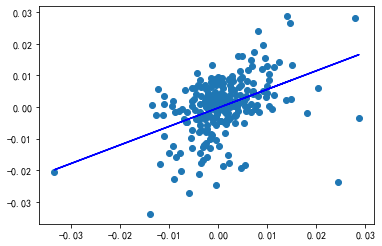

In [18]:
#上述排序法得到的OEF结果作图
coef=results.params
plt.scatter(res,yy)
ybar=coef[0]+np.array(res)*coef[1]
plt.plot(res,ybar,color='b')

### 双重排序

In [69]:
#市值数据读取
CAPS=pd.read_csv('input/SP100_MarketCap_70stocks_2017.csv').iloc[:,1:]
CAPS=torch.tensor(CAPS[:251].values).cuda().detach() #读取251天

In [70]:
M=23 #按照市值分三组 23，24，23
LCAPSindex=CAPS.sort().indices[:,:M]
MCAPSindex=CAPS.sort().indices[:,M:70-M]
HCAPSindex=CAPS.sort().indices[:,70-M:]

In [71]:
LCAPbeta=torch.zeros([251,M]).cuda().detach() 
HCAPbeta=torch.zeros([251,M]).cuda().detach() 
MCAPbeta=torch.zeros([251,70-2*M]).cuda().detach() 
for i in range(251):
    LCAPbeta[i]=Betas[i,LCAPSindex[i]]
    HCAPbeta[i]=Betas[i,HCAPSindex[i]]
    MCAPbeta[i]=Betas[i,MCAPSindex[i]]

In [72]:
LCAPSP=torch.zeros([250,M]).cuda().detach() 
HCAPSP=torch.zeros([250,M]).cuda().detach() 
MCAPSP=torch.zeros([251,70-2*M]).cuda().detach() 
for i in range(250):
    LCAPSP[i]=ReSP[i,LCAPSindex[i]]
    HCAPSP[i]=ReSP[i,HCAPSindex[i]]
    MCAPSP[i]=ReSP[i,MCAPSindex[i]]

In [87]:
# CAP1 CAP2 CAP3三组组内按照beta排序，取最大7个为高beta组 最小7个为低beta组
NN=7
LCAPRe1=torch.zeros([250]).cuda().detach() 
LCAPRe2=torch.zeros([250]).cuda().detach() 
 
HCAPRe1=torch.zeros([250]).cuda().detach() 
HCAPRe2=torch.zeros([250]).cuda().detach() 

MCAPRe1=torch.zeros([250]).cuda().detach() 
MCAPRe2=torch.zeros([250]).cuda().detach()

for i in range(250):
    LCAPRe1[i]=(LCAPSP[i,LCAPbeta[i].sort().indices[:NN]]).mean()
    LCAPRe2[i]=(LCAPSP[i,LCAPbeta[i].sort().indices[M-NN:M]]).mean()
    
    HCAPRe1[i]=(HCAPSP[i,HCAPbeta[i].sort().indices[:NN]]).mean()
    HCAPRe2[i]=(HCAPSP[i,HCAPbeta[i].sort().indices[M-NN:M]]).mean()
    
    MCAPRe1[i]=(MCAPSP[i,MCAPbeta[i].sort().indices[:NN]]).mean()
    MCAPRe2[i]=(MCAPSP[i,MCAPbeta[i].sort().indices[M-NN:M]]).mean()

In [88]:
#控制市值变量后的高beta-低beta组合收益率
RES=-LCAPRe1-HCAPRe1-MCAPRe1+LCAPRe2+HCAPRe2+MCAPRe2

In [89]:
ss.ttest_1samp(RES.tolist(),0)

Ttest_1sampResult(statistic=1.7605755414575202, pvalue=0.0795378888064545)

In [90]:
xx=sm.add_constant(RES.tolist())
yy=np.array((ReOEF.view(250)).tolist()).reshape(250)
model = sm.OLS(yy,xx)
results = model.fit()
results .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     48.77
Date:                Tue, 26 Apr 2022   Prob (F-statistic):           2.63e-11
Time:                        14:54:40   Log-Likelihood:                 843.32
No. Observations:                 250   AIC:                            -1683.
Df Residuals:                     248   BIC:                            -1676.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.477      0.634      -0.001       0.001
x1             0.1910      0.027      6.983      0.000       0.137       0.245
==============================================================================
Omnibus:                       38.916   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.435
Skew:                          -0.844   Prob(JB):                     1.38e-15
Kurtosis:                       4.929   Cond. No.                         51.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 回归方法检验

In [103]:
#205天截面回归，得到每日市场因子收益率估计值
import statsmodels.api as sm
# 模型训练

bbb=[]
aaa=[]
rrr=[]
X=Betas[1:].cpu().numpy()
Y=ReSP.cpu().numpy()
for i in range(250):
    #temp=np.polyfit(ReSP[50*N:50*(N+1),i].tolist(),ReOEF[50*N:50*(N+1)].tolist(),deg=1)
    #temp=np.polyfit(ReSP[:,i].tolist(),RMF[],deg=1)
    x= sm.add_constant(X[i,:])
    model = sm.OLS(Y[i,:],x).fit()
    bbb.append(list(model.params))
    aaa.append(list(model.pvalues))
    rrr.append((model.resid**2).sum())

In [104]:
bbb=np.array(bbb)
aaa=np.array(aaa)

In [105]:
np.count_nonzero(aaa < 0.05, axis=0)

array([118, 161], dtype=int64)

In [106]:
X=sm.add_constant(bbb[:,1])
Y=np.array((ReOEF.view(250)).tolist()).reshape(250)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     306.5
Date:                Sun, 24 Apr 2022   Prob (F-statistic):           3.15e-45
Time:                        13:59:23   Log-Likelihood:                 921.46
No. Observations:                 250   AIC:                            -1839.
Df Residuals:                     248   BIC:                            -1832.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.935      0.351      -0.000       0.001
x1             0.9554      0.055     17.508      0.000       0.848       1.063
==============================================================================
Omnibus:                       18.194   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.659
Skew:                          -0.148   Prob(JB):                     1.35e-12
Kurtosis:                       5.271   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'OEF收益率')

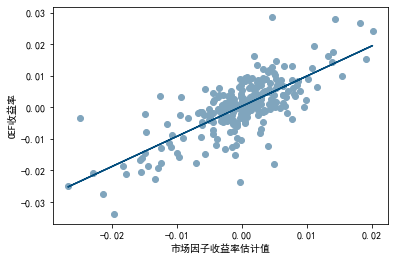

In [110]:
coef=results.params
X=bbb[:,1]
Y=np.array((ReOEF.view(250)).tolist())
Ybar=coef[0]+X*coef[1]
plt.scatter(X,Y,color=colorset[3])
plt.plot(X,Ybar,color=colorset[1])
plt.xlabel("市场因子收益率估计值")
plt.ylabel("OEF收益率")

## BAB异象

In [240]:
BetaB=Betas[1:]

In [243]:
Resid=ReSP-BetaB*ReOEF

In [244]:
Resid

tensor([[ 0.0165, -0.0047, -0.0023,  ...,  0.0056,  0.0029, -0.0023],
        [ 0.0135,  0.0035,  0.0019,  ...,  0.0024,  0.0064,  0.0067],
        [ 0.0033, -0.0006,  0.0078,  ..., -0.0043,  0.0008, -0.0022],
        ...,
        [ 0.0092, -0.0019, -0.0037,  ...,  0.0094,  0.0426,  0.0066],
        [ 0.0055, -0.0100, -0.0017,  ...,  0.0034, -0.0091, -0.0043],
        [-0.0160,  0.0292, -0.0125,  ...,  0.0149, -0.0019, -0.0028]],
       device='cuda:0')

In [245]:
model = sm.OLS(Resid.view(-1).cpu().numpy(),sm.add_constant(BetaB.view(-1).cpu().numpy()))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 2.662e+04
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:23:22   Log-Likelihood:                 42887.
No. Observations:               17500   AIC:                        -8.577e+04
Df Residuals:                   17498   BIC:                        -8.575e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.000     20.294      0.000       0.003       0.004
x1            -0.0029    1.8e-05   -163.164      0.000      -0.003      -0.003
==============================================================================
Omnibus:                     7709.447   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25345151.322
Skew:                          -0.147   Prob(JB):                         0.00
Kurtosis:                     189.438   Cond. No.                         8.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""